In [1]:
#Importamos las librerías a usar
import warnings
import pandas as pd
from datetime import datetime
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf

Using TensorFlow backend.


In [4]:
#Cargamos los conjuntos de datos

Boya3_00 = pd.read_csv('../Fase_2/Paso 4/Boya3_00_conduc_train.csv', sep=",", decimal=".")
Boya3_00['Date'] = pd.to_datetime(Boya3_00['Date'],format="%d/%m/%Y").astype(np.int64) // 10 ** 9
Boya3_00_train = Boya3_00[0:56]
Boya3_15 = pd.read_csv('../Fase_2/Paso 4/Boya3_15_conduc_test.csv', sep=",", decimal=".")
Boya3_15['Date'] = pd.to_datetime(Boya3_15['Date'],format="%d/%m/%Y").astype(np.int64) // 10 ** 9
Boya3_15_test = Boya3_15[0:20]

In [5]:
EPOCHS = 40
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(1, input_shape=(1,),activation='tanh'))
    #model.add(Flatten()) No se puede usar porque solo hay un input
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mean_squared_error"])
    model.summary()
    return model

In [30]:
from sklearn.externals import joblib

#Primer escenario
scaler = MinMaxScaler(feature_range=(-1, 1))
train = Boya3_00_train.values
test = Boya3_15_test.values
full = np.append(train,test,axis=0)
full = full.astype(np.float64)
full[:,1] = scaler.fit_transform(full[:,1].reshape(-1,1)).reshape(1,-1)
train = full[0:56]
test = full[56:76]

joblib.dump(scaler, "escala_escenario_1.scale") 
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]


In [21]:
model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=7)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
Train on 56 samples, validate on 20 samples
Epoch 1/40
56/56 [==============================] - 0s 4ms/step - loss: 0.6145 - mean_squared_error: 0.5445 - val_loss: 0.3177 - val_mean_squared_error: 0.1193
Epoch 2/40
56/56 [==============================] - 0s 552us/step - loss: 0.6057 - mean_squared_error: 0.5326 - val_loss: 0.3089 - val_mean_squared_error: 0.1134
Epoch 3/40
56/56 [==============================] - 0s 463us/step - loss: 0.5967 - mean_squared_error: 0.5213 - val_loss: 0.2999 - val_mean_squared_error: 0

Text(0.5, 1.0, 'validate')

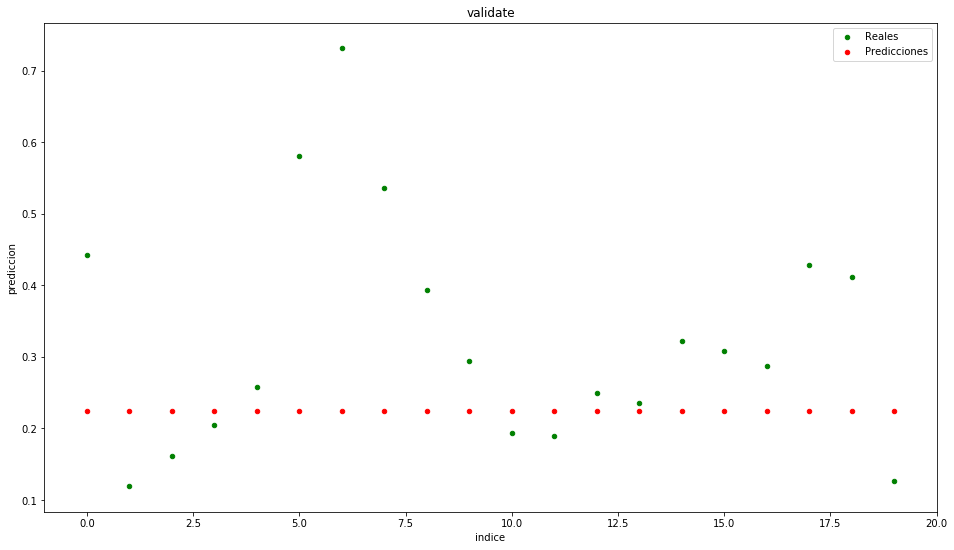

In [22]:
results=model.predict(x_val)
def sacarResultados(results):
    return [x[0] for x in results]
resultados = sacarResultados(results)
validacion = pd.DataFrame({"reales":y_val,"prediccion":resultados})
validacion['indice'] = range(0,20)
#validacion.plot.scatter(x="indice)
ax1 = validacion.plot(kind="scatter",x="indice",y="reales", color="g",label="Reales")
validacion.plot(kind="scatter",x="indice",y="prediccion", ax=ax1, color="r",label="Predicciones")
plt.title('validate')

Text(0.5, 1.0, 'Validate loss')

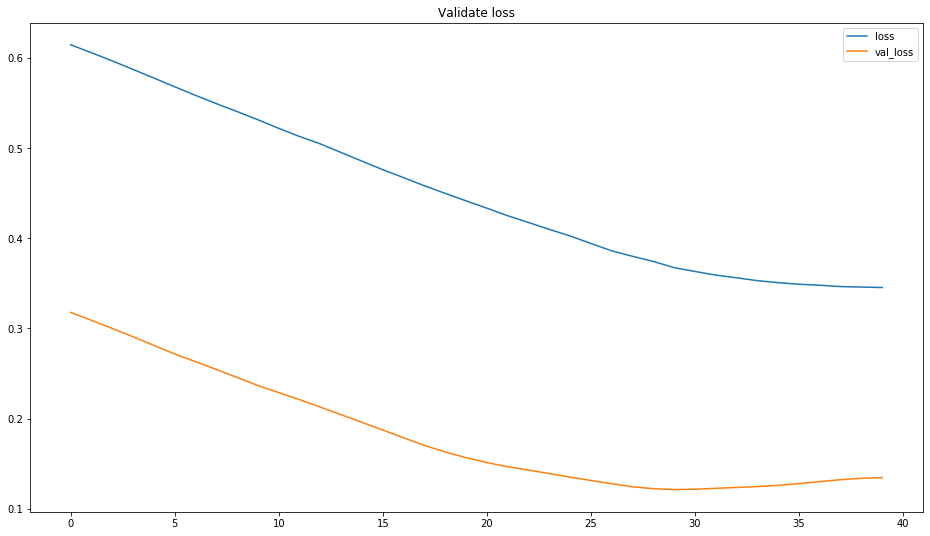

In [23]:
validate_loss = pd.DataFrame({"loss":history.history['loss'],"val_loss":history.history['val_loss']})
validate_loss.plot()
plt.title("Validate loss")

In [24]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = abs(compara2['real'] - compara2['prediccion'])
compara2.head()

,real,prediccion,diferencia
0,0.076958,0.071561,0.005398
1,0.068958,0.071561,0.002602
2,0.070000,0.071561,0.001561
3,0.071083,0.071561,0.000477
4,0.072375,0.071561,0.000814


In [25]:
compara2.describe()

,real,prediccion,diferencia
count,20.000000,2.000000e+01,20.000000
mean,0.074010,7.156070e-02,0.003319
std,0.003973,1.423831e-17,0.003241
min,0.068958,7.156070e-02,0.000273
25%,0.071010,7.156070e-02,0.000843
50%,0.073208,7.156070e-02,0.002231
75%,0.076271,7.156070e-02,0.004710
max,0.084083,7.156070e-02,0.012523


Text(0.5, 1.0, 'Comparación predicciones')

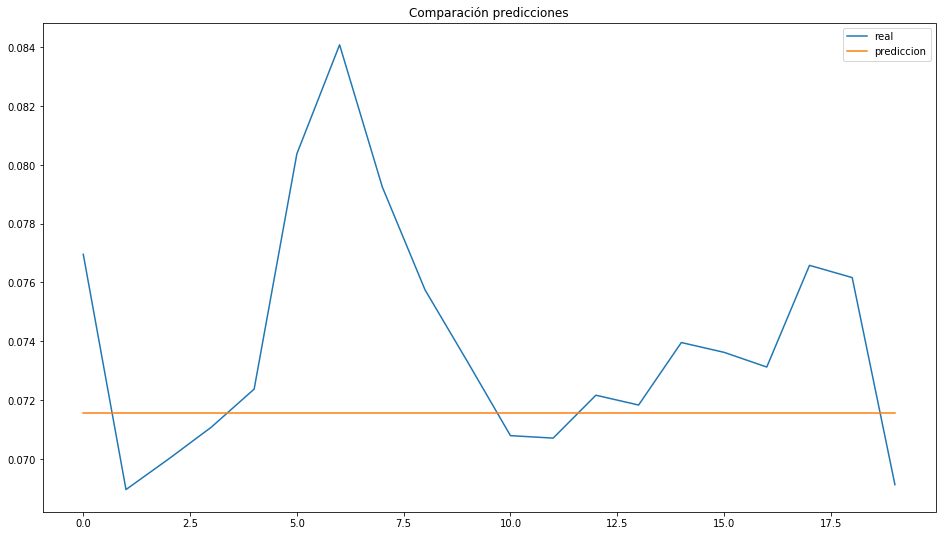

In [26]:
comparacion_predicciones = pd.DataFrame({"real":compara2['real'],"prediccion":compara2['prediccion']})
comparacion_predicciones.plot()
plt.title("Comparación predicciones")

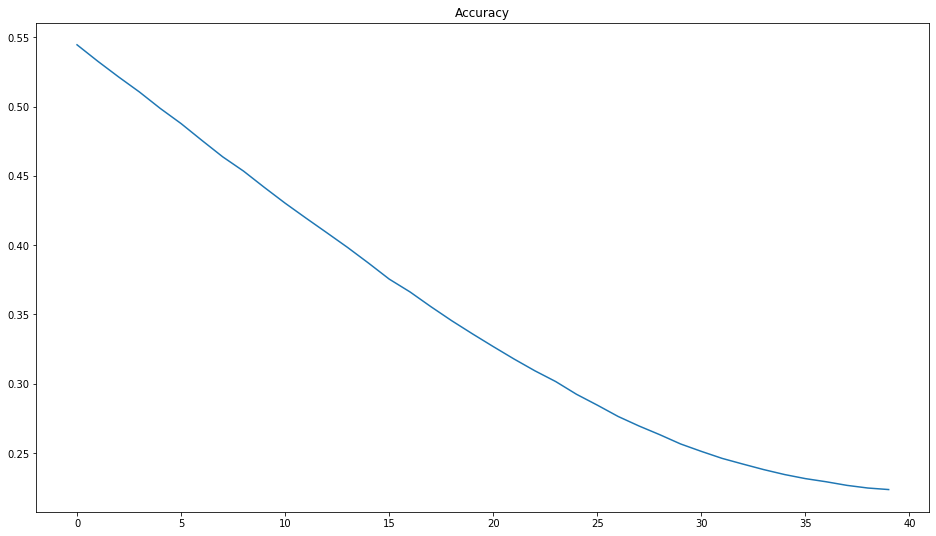

In [27]:
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [28]:
model.save('escenario_1.h5')